In [4]:
 import backtrader as bt

In [8]:
# Create a Stratey
class macrossover(bt.Strategy):
    #default parameters
    params = (('pfast',5),('pslow',50))

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        
        self.buyprice = 0
        self.order = None
        
        self.sma_fast = bt.indicators.SimpleMovingAverage(self.datas[0],period = self.params.pfast)
        self.sma_slow = bt.indicators.SimpleMovingAverage(self.datas[0],period = self.params.pslow)

        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('Close, %.2f' % self.dataclose[0])
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            if self.sma_fast[0] > self.sma_slow[0] and self.sma_fast[-1] < self.sma_slow[-1]:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.buyprice = self.dataclose[0]
                self.buy()
                
                
        else:

            # Already in the market ... we might sell
            if (self.dataclose[0] >= self.buyprice * 1.05 or self.dataclose[0] <= self.buyprice * 0.95) or  (self.sma_fast[0] < self.sma_slow[0] and self.sma_fast[-1] > self.sma_slow[-1]) :
                #Target or stoploss or buy signal generated
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                #create sell order
                self.order = self.sell

In [12]:
class Bollinger(bt.Strategy):
    params = (('maperiod',20),('dev',1))

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.bar_executed = 0
        self.buyprice = 0
        self.order = None
        
        self.bband = bt.indicators.BollingerBands(self.datas[0], period = self.p.maperiod, devfactor = self.p.dev)


        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('Close, %.2f' % self.dataclose[0])
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            if self.dataclose[0] < self.bband.lines.bot:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.buyprice = self.dataclose[0]
                self.buy()
                
                
        else:

            # Already in the market ... we might sell
            if (self.dataclose[0] >= self.buyprice * 1.05) or self.dataclose[0] > self.bband.lines.top  :
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()



In [13]:
class RSI(bt.Strategy):
    params = (('upperband', 70),('lowerband', 30),)

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        
        self.buyprice = 0
        self.order = None
        
        self.rsi = bt.indicators.RSI(self.data)


        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('Close, %.2f' % self.dataclose[0])
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            if self.rsi < self.p.lowerband:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.buyprice = self.dataclose[0]
                self.buy()
                
                
        else:

            # Already in the market ... we might sell
            if (self.dataclose[0] >= self.buyprice * 1.05 or self.dataclose[0] <= self.buyprice * 0.95) or self.rsi > self.p.upperband :
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()




In [9]:
def implement_strategy(strategy):
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(strategy)

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(dataname='RELIANCE.NS.csv')

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Print out the starting conditions
    start_portfolio_value = cerebro.broker.getvalue()

    # Run over everything
    cerebro.run()
    
    end_portfolio_value =  cerebro.broker.getvalue()

    # Print out the final result
   
    print("Starting portfolio value: %s \nEnding portfolio value: %s \nPnl: %s" \
          %(start_portfolio_value,end_portfolio_value,end_portfolio_value-start_portfolio_value))
    cerebro.plot()
      
    

2020-01-13, BUY CREATE, 1537.93
2020-01-14, BUY EXECUTED, 1534.24
2020-01-23, SELL CREATE, 1521.14
Starting portfolio value: 100000.0 
Ending portfolio value: 100790.31 
Pnl: 790.3099999999977


<IPython.core.display.Javascript object>


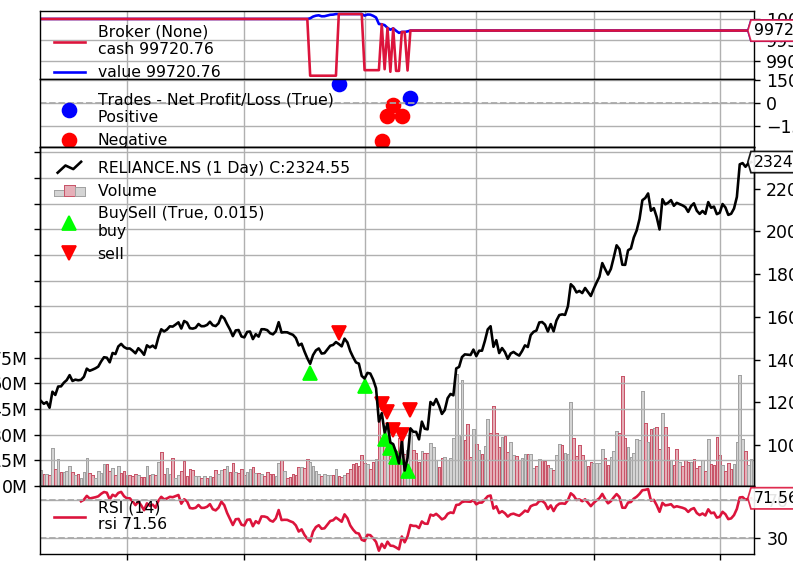

In [10]:
implement_strategy(macrossover)

In [14]:
implement_strategy(Bollinger)

2019-12-24, BUY CREATE, 1540.67
2019-12-26, BUY EXECUTED, 1535.88
2020-01-17, SELL CREATE, 1575.09
2020-01-20, SELL EXECUTED, 1602.98
2020-01-27, BUY CREATE, 1500.91
2020-01-28, BUY EXECUTED, 1502.96
2020-02-19, SELL CREATE, 1498.17
2020-02-20, SELL EXECUTED, 1491.40
2020-02-25, BUY CREATE, 1411.10
2020-02-26, BUY EXECUTED, 1404.73
2020-04-07, SELL CREATE, 1201.59
2020-04-08, SELL EXECUTED, 1175.59
2020-08-31, BUY CREATE, 2080.70
2020-09-01, BUY EXECUTED, 2100.00
2020-09-09, SELL CREATE, 2161.35
2020-09-10, SELL EXECUTED, 2183.10
Starting portfolio value: 100000.0 
Ending portfolio value: 99909.49999999999 
Pnl: -90.50000000001455


In [15]:
implement_strategy(RSI)

2020-01-31, BUY CREATE, 1406.37
2020-02-03, BUY EXECUTED, 1364.78
2020-02-14, SELL CREATE, 1482.04
2020-02-17, SELL EXECUTED, 1483.43
2020-02-28, BUY CREATE, 1323.68
2020-03-02, BUY EXECUTED, 1350.03
2020-03-09, SELL CREATE, 1109.98
2020-03-11, SELL EXECUTED, 1103.86
2020-03-11, BUY CREATE, 1149.23
2020-03-12, BUY EXECUTED, 1080.94
2020-03-12, SELL CREATE, 1059.02
2020-03-13, SELL EXECUTED, 994.27
2020-03-13, BUY CREATE, 1101.17
2020-03-16, BUY EXECUTED, 1056.58
2020-03-16, SELL CREATE, 1011.90
2020-03-17, SELL EXECUTED, 1043.33
2020-03-17, BUY CREATE, 1004.23
2020-03-18, BUY EXECUTED, 1021.46
2020-03-19, SELL CREATE, 914.27
2020-03-20, SELL EXECUTED, 935.99
2020-03-23, BUY CREATE, 880.74
2020-03-24, BUY EXECUTED, 926.52
2020-03-24, SELL CREATE, 939.87
2020-03-25, SELL EXECUTED, 960.19
Starting portfolio value: 100000.0 
Ending portfolio value: 99720.76 
Pnl: -279.24000000000524
